# Deep Learning NER task

Tatjana Cucic and Sanna Volanen

https://spacy.io/api/annotation

# Milestones

## 1.1 Predicting word labels independently

* The first part is to train a classifier which assigns a label for each given input word independently. 
* Evaluate the results on token level and entity level. 
* Report your results with different network hyperparameters. 
* Also discuss whether the token level accuracy is a reasonable metric.









In [1]:
# Training data: Used for training the model
!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/train.tsv

# Development/ validation data: Used for testing different model parameters, for example level of regularization needed
!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/dev.tsv

# Test data: Never touched during training / model development, used for evaluating the final model
!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/test.tsv

#saved model
!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/saved_models/Adamax90.h5



--2020-05-19 08:37:36--  https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17252156 (16M) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]  16.45M  53.4MB/s    in 0.3s    

2020-05-19 08:37:37 (53.4 MB/s) - ‘train.tsv’ saved [17252156/17252156]

--2020-05-19 08:37:39--  https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2419425 (2.3M) [text/plain]
Saving t

In [2]:
import os
import sys 
import csv

csv.field_size_limit(sys.maxsize)

131072

In [0]:
#read tsv data to list of lists of lists: a list of sentences that contain lists of tokens that are lists of unsplit \t lines from the tsv, such as ['attract\tO']
token = {"word":"","entity_label":""}

def read_ontonotes(tsv_file): # 
    current_sent = [] # list of (word,label) lists
    #with open(tsv_file) as f:
    with open(tsv_file, "r", encoding="utf-8") as f:
        tsvreader = csv.reader(f, delimiter= '\n')
        for line in tsvreader:
            #print(line)
            if not line:
                if current_sent:
                    yield current_sent
                    current_sent=[]
                continue
            current_sent.append(line[0]) 
        else:
            if current_sent:
                yield current_sent

train_data_full = list(read_ontonotes('train.tsv'))
dev_data_full = list(read_ontonotes('dev.tsv'))
test_data_full = list(read_ontonotes('test.tsv'))

In [17]:
train_data_full[7]

['And\tO',
 'what\tO',
 'effect\tO',
 'does\tO',
 'their\tO',
 'return\tO',
 'have\tO',
 'on\tO',
 'campus\tO',
 '?\tO']

In [18]:
import re
from pprint import pprint
#regex for empty space chars, \t \n
tab = re.compile('[\t]')
line = re.compile('[\n]')
punct = re.compile('[.?!:;]')

def splitter(sent):
    #print('----------------------------------------')
    #print("one sentence in raw data:", sent)
    split_list = []
    # loop over tokens items inside sentence, supposedly item= token+ \t +tag
    for item in sent: 
        #print("Item in sentence: ", item)
        if item != None:
            match1 = item.count('\n')
            #print(match1)
            match2 = item.count('\t')
            #print(match2)
            if match1 ==0: # no new lines nested
                if match2 == 1: #just one tab inside token
                    item_pair = item.split('\t')
                if item_pair[0] =='': # replacing empty string with missing quote marks
                    item_pair[0] = '\"'
                split_list.append(item_pair) 
            else:
                subitems_list = item.split('\n') ## check if token has \n -> bundled, quotes
                if len(subitems_list) > 1:  ## item string has more than one sentence nested in it
                    #print("Found nested sentences: ", subitems_list)
                    #print("subseq start")
                    for j in range(len(subitems_list)):  
                        token = subitems_list[j]  
                        #print(token)
                        subtoken_listed_again = token.split('\n') 
                        for token in subtoken_listed_again:
                            match1=token.count('\n')
                            match2=token.count('\t')
                            if  match1 == 0: # no new lines nested
                               if  match2 == 1: #just one tab inside token
                                    token = token.split('\t')
                            if token =='': # replacing empty string with missing quote marks
                                token = '\"'
                            if token == '.':
                                split_list.append(token)
                                continue
                                split_list=[]
                            else:
                                split_list.append(token)
                    #print("subseq end")
    for item in split_list:
        #print("Item in split list: ",item)
        if type(item) != list:
            split_list.remove(item)
        if item[0] =='': # replacing empty string with missing quote marks
            item[0] = '\"'
    #print("Resplitted sentence :", split_list)
    return split_list

def clean(raw_data): ## input list is list of lists of strings 
    clean_data =[]  #list of lists that have one clean sentence per list
    for sent in raw_data: # split by [] lines, supposedly a sentence line
        one_sentence = [] #collects the new sentence if there has been need to resplit items
        splitted= splitter(sent)
        for item in splitted:
            #print(item)
            matchi = re.match(punct, item[0])
            if matchi:
                #print("collected sentence")
                one_sentence.append(item)
                clean_data.append(one_sentence)
                one_sentence=[]
                break
            else:
                one_sentence.append(item)

    return clean_data

train_data_clean = clean(train_data_full)
print(len(train_data_clean))
for item in train_data_clean[:3]:
    print(item)

50252
[['In', 'O'], ['recent', 'B-DATE'], ['years', 'I-DATE'], [',', 'O'], ['advanced', 'O'], ['education', 'O'], ['for', 'O'], ['professionals', 'O'], ['has', 'O'], ['become', 'O'], ['a', 'O'], ['hot', 'O'], ['topic', 'O'], ['in', 'O'], ['the', 'O'], ['business', 'O'], ['community', 'O'], ['.', 'O']]
[['With', 'O'], ['this', 'O'], ['trend', 'O'], [',', 'O'], ['suddenly', 'O'], ['the', 'O'], ['mature', 'O'], ['faces', 'O'], ['of', 'O'], ['managers', 'O'], ['boasting', 'O'], ['an', 'O'], ['average', 'O'], ['of', 'O'], ['over', 'O'], ['ten', 'B-DATE'], ['years', 'I-DATE'], ['of', 'O'], ['professional', 'O'], ['experience', 'O'], ['have', 'O'], ['flooded', 'O'], ['in', 'O'], ['among', 'O'], ['the', 'O'], ['young', 'O'], ['people', 'O'], ['populating', 'O'], ['university', 'O'], ['campuses', 'O'], ['.', 'O']]
[['In', 'O'], ['order', 'O'], ['to', 'O'], ['attract', 'O'], ['this', 'O'], ['group', 'O'], ['of', 'O'], ['seasoned', 'O'], ['adults', 'O'], ['pulling', 'O'], ['in', 'O'], ['over', 'O

In [19]:
# final check on the sentences
item_lengths = []
max_text = 0
for item in train_data_clean:
    item_lengths.append(len(item))
    if len(item) > max_text:
        max_text = len(item)
        ind = train_data_clean.index(item)
print("Longest sentence:", max_text, "index: ",ind)

lengths_sorted = sorted(item_lengths, reverse=True)
max = item_lengths.index(max_text)
#print(items_sorted[0])
#pprint(train_data_clean[max])
print(lengths_sorted[:300]) # longest sentences
# checking long items
#for item in train_data_clean:
    #if len(item) == 123:
        #pprint(item)

Longest sentence: 168 index:  8041
[168, 145, 123, 121, 120, 108, 106, 106, 102, 101, 97, 96, 94, 94, 93, 93, 93, 92, 91, 91, 91, 90, 90, 90, 90, 90, 90, 89, 88, 88, 88, 87, 87, 86, 85, 85, 85, 85, 84, 84, 84, 84, 83, 83, 83, 83, 82, 82, 82, 82, 81, 81, 80, 80, 80, 79, 79, 79, 79, 79, 79, 78, 78, 78, 78, 78, 77, 77, 77, 77, 77, 77, 77, 77, 76, 76, 76, 76, 76, 76, 76, 76, 76, 75, 75, 75, 75, 75, 75, 75, 75, 75, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64

In [20]:
import numpy as np   #want to see the longest sentence

lengths = np.array(item_lengths)
train_data_clean[np.argmax(lengths)]

[['A', 'O'],
 ['rational', 'O'],
 ['approach', 'O'],
 ['to', 'O'],
 ['transportation', 'O'],
 ['would', 'O'],
 ['entail', 'O'],
 ['(', 'O'],
 ['1', 'O'],
 [')', 'O'],
 ['creating', 'O'],
 ['communities', 'O'],
 ['with', 'O'],
 ['a', 'O'],
 ['mix', 'O'],
 ['of', 'O'],
 ['housing', 'O'],
 ['/', 'O'],
 ['office', 'O'],
 ['/', 'O'],
 ['retail', 'O'],
 ['/', 'O'],
 ['amenities', 'O'],
 ['to', 'O'],
 ['reduce', 'O'],
 ['the', 'O'],
 ['number', 'O'],
 ['and', 'O'],
 ['length', 'O'],
 ['of', 'O'],
 ['automobile', 'O'],
 ['trips', 'O'],
 [',', 'O'],
 ['(', 'O'],
 ['2', 'O'],
 [')', 'O'],
 ['reforming', 'O'],
 ['counterproductive', 'O'],
 ['zoning', 'O'],
 ['codes', 'O'],
 [',', 'O'],
 ['subdivision', 'O'],
 ['ordinances', 'O'],
 ['and', 'O'],
 ['comprehensive', 'O'],
 ['plans', 'O'],
 ['in', 'O'],
 ['order', 'O'],
 ['to', 'O'],
 ['create', 'O'],
 ['more', 'O'],
 ['transit', 'O'],
 ['-', 'O'],
 ['friendly', 'O'],
 ['and', 'O'],
 ['pedestrian', 'O'],
 ['-', 'O'],
 ['friendly', 'O'],
 ['communitie

In [21]:
train_data_clean[0]

[['In', 'O'],
 ['recent', 'B-DATE'],
 ['years', 'I-DATE'],
 [',', 'O'],
 ['advanced', 'O'],
 ['education', 'O'],
 ['for', 'O'],
 ['professionals', 'O'],
 ['has', 'O'],
 ['become', 'O'],
 ['a', 'O'],
 ['hot', 'O'],
 ['topic', 'O'],
 ['in', 'O'],
 ['the', 'O'],
 ['business', 'O'],
 ['community', 'O'],
 ['.', 'O']]

In [22]:

print('------------------------------------------')
dev_data_clean = clean(dev_data_full)
print(len(dev_data_clean))
for item in dev_data_clean[:3]:
    print(item)
print('------------------------------------------')
test_data_clean = clean(test_data_full)
print(len(test_data_clean))
for item in test_data_clean[:3]:
    print(item)
print('------------------------------------------')    

------------------------------------------
9954
[['President', 'O'], ['Chen', 'B-PERSON'], ['Shui', 'I-PERSON'], ['-', 'I-PERSON'], ['bian', 'I-PERSON'], ['visited', 'O'], ['the', 'B-FAC'], ['Nicaraguan', 'I-FAC'], ['National', 'I-FAC'], ['Assembly', 'I-FAC'], ['on', 'O'], ['August', 'B-DATE'], ['17', 'I-DATE'], [',', 'O'], ['where', 'O'], ['he', 'O'], ['received', 'O'], ['a', 'O'], ['medal', 'O'], ['from', 'O'], ['the', 'O'], ['president', 'O'], ['of', 'O'], ['the', 'O'], ['assembly', 'O'], [',', 'O'], ['Ivan', 'B-PERSON'], ['Escobar', 'I-PERSON'], ['Fornos', 'I-PERSON'], ['.', 'O']]
[['On', 'O'], ['August', 'B-DATE'], ['25', 'I-DATE'], ['President', 'O'], ['Chen', 'B-PERSON'], ['Shui', 'I-PERSON'], ['-', 'I-PERSON'], ['bian', 'I-PERSON'], ['wrapped', 'O'], ['up', 'O'], ['his', 'O'], ['first', 'B-ORDINAL'], ['overseas', 'O'], ['trip', 'O'], ['since', 'O'], ['taking', 'O'], ['office', 'O'], [',', 'O'], ['swinging', 'O'], ['through', 'O'], ['three', 'B-CARDINAL'], ['countries', 'O'], ['

In [23]:
# shape into dicts per sentence

def reshape_sent2dicts(f):
    data_dict = []
    for item in f: # list of lists (tokens)
        #print(item)
        sent_text= [] 
        sent_tags = []
        for token in item:
            if len(token) ==2:
                sent_text.append(token[0])
                sent_tags.append(token[1])
        sent_dict = {'text':sent_text,'tags':sent_tags }
        #print(sent_dict['text'])
        #print(sent_dict['tags'])
        data_dict.append(sent_dict)
    return data_dict

train_data_sent = list(reshape_sent2dicts(train_data_clean[:30000]))
samp = train_data_sent[:2]
print(samp)
print()
dev_data_sent = list(reshape_sent2dicts(dev_data_clean))
samp2 = dev_data_sent[:3]
print(samp2)

[{'text': ['In', 'recent', 'years', ',', 'advanced', 'education', 'for', 'professionals', 'has', 'become', 'a', 'hot', 'topic', 'in', 'the', 'business', 'community', '.'], 'tags': ['O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, {'text': ['With', 'this', 'trend', ',', 'suddenly', 'the', 'mature', 'faces', 'of', 'managers', 'boasting', 'an', 'average', 'of', 'over', 'ten', 'years', 'of', 'professional', 'experience', 'have', 'flooded', 'in', 'among', 'the', 'young', 'people', 'populating', 'university', 'campuses', '.'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}]

[{'text': ['President', 'Chen', 'Shui', '-', 'bian', 'visited', 'the', 'Nicaraguan', 'National', 'Assembly', 'on', 'August', '17', ',', 'where', 'he', 'received', 'a', 'medal', 'from', 'the', 'president', 'of', 'the', 'assembly', ',', 'Ivan', 

In [24]:
import random
import numpy

random.seed(123)
random.shuffle(train_data_sent)
#max_sent = [max(len(i["text"])) for i in train_data_sent]
#print(max_sent)
print(type(train_data_sent))
print(train_data_sent[0]) ##one dict
print()
print(train_data_sent[0]["text"])
print()
print(train_data_sent[0]["tags"])
print('------------')

def typed_listing(data, key):
    listed = []
    max_length = 0
    for item in data: # dictionary {text:"", tags:""}
        #print('Item: ', item)
        #print('Key: ', key, ' content: ', item[key], 'length: ',len(item[key]))
        if len(item[key]) > max_length:
            max = len(item[key])
        listed.append(item[key])
    return listed, max_length

listed_texts= typed_listing(train_data_sent, "text")
train_texts = listed_texts[0]
train_txt_max = listed_texts[1]
listed_labels = typed_listing(train_data_sent, "tags")
train_labels= listed_labels[0]
train_lbl_max = listed_labels[1]
print(train_txt_max)
print(train_texts[0])
print(train_labels[0])


print('-----------------------------')
print(len(train_texts))
print('-----------------------')
print('Text: ', train_texts[0])
print(' Texts length: ',len(train_texts))
print('Label: ', train_labels[0])
print(' Labels length: ',len(train_labels))


<class 'list'>
{'text': ['Does', 'it', 'wake', 'you', 'up', '?'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O']}

['Does', 'it', 'wake', 'you', 'up', '?']

['O', 'O', 'O', 'O', 'O', 'O']
------------
0
['Does', 'it', 'wake', 'you', 'up', '?']
['O', 'O', 'O', 'O', 'O', 'O']
-----------------------------
30000
-----------------------
Text:  ['Does', 'it', 'wake', 'you', 'up', '?']
 Texts length:  30000
Label:  ['O', 'O', 'O', 'O', 'O', 'O']
 Labels length:  30000


In [25]:
## same for validation/dev data
listed_texts= typed_listing(dev_data_sent, "text")
dev_texts = listed_texts[0]
dev_txt_max = listed_texts[1]
listed_labels = typed_listing(dev_data_sent, "tags")
dev_labels= listed_labels[0]
dev_lbl_max = listed_labels[1]
print('Text: ', dev_texts[0])
print(' Texts length: ',len(dev_texts))
print('Label: ', dev_labels[0])
print(' Labels length: ',len(dev_labels))


Text:  ['President', 'Chen', 'Shui', '-', 'bian', 'visited', 'the', 'Nicaraguan', 'National', 'Assembly', 'on', 'August', '17', ',', 'where', 'he', 'received', 'a', 'medal', 'from', 'the', 'president', 'of', 'the', 'assembly', ',', 'Ivan', 'Escobar', 'Fornos', '.']
 Texts length:  9954
Label:  ['O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'B-FAC', 'I-FAC', 'I-FAC', 'I-FAC', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O']
 Labels length:  9954


In [26]:
# Load pretrained embeddings
!wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


--2020-05-19 08:46:17--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4a8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  11.3MB/s    in 66s     

2020-05-19 08:47:25 (9.80 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [27]:
# Give -n argument so that a possible existing file isn't overwritten 
!unzip -n wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [28]:
from gensim.models import KeyedVectors

vector_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary=False, limit=50000)


# sort based on the index to make sure they are in the correct order
words = [k for k, v in sorted(vector_model.vocab.items(), key=lambda x: x[1].index)]
print("Words from embedding model:", len(words))
print("First 50 words:", words[:50])

# Normalize the vectors to unit length
print("Before normalization:", vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:", vector_model.get_vector("in")[:10])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']
Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


In [29]:
# Build vocabulary mappings

# Zero is used for padding in Keras, prevent using it for a normal word.
# Also reserve an index for out-of-vocabulary items.
vocabulary={
    "<PAD>": 0,
    "<OOV>": 1
}

for word in words: # These are words from the word2vec model
    vocabulary.setdefault(word, len(vocabulary))

print("Words in vocabulary:",len(vocabulary))
inv_vocabulary = { value: key for key, value in vocabulary.items() } # invert the dictionary


# Embedding matrix
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings = numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab)-1,embedding_model.vectors.shape[1]))
    pretrained_embeddings = numpy.vstack((numpy.zeros(shape=(1,embedding_model.vectors.shape[1])), pretrained_embeddings))
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)

Words in vocabulary: 50002
Found pretrained vectors for 50000 words.


Preprocessing

In [30]:
#Labels


not_letter = re.compile(r'[^a-zA-Z]')
# Label mappings
# 1) gather a set of unique labels
label_set = set()
for sentence_labels in train_labels: #loops over sentences 
    #print(sentence_labels)
    for label in sentence_labels: #loops over labels in one sentence
       # match = not_letter.match(label)
        #if match or label== 'O':
        #    break
        #else:    
        label_set.add(label)

# 2) index these
label_map = {}
for index, label in enumerate(label_set):
    label_map[label]=index
    
pprint(label_map)

{'B-CARDINAL': 1,
 'B-DATE': 0,
 'B-EVENT': 18,
 'B-FAC': 25,
 'B-GPE': 19,
 'B-LANGUAGE': 32,
 'B-LAW': 14,
 'B-LOC': 30,
 'B-MONEY': 9,
 'B-NORP': 10,
 'B-ORDINAL': 20,
 'B-ORG': 27,
 'B-PERCENT': 11,
 'B-PERSON': 17,
 'B-PRODUCT': 24,
 'B-QUANTITY': 4,
 'B-TIME': 16,
 'B-WORK_OF_ART': 28,
 'I-CARDINAL': 8,
 'I-DATE': 33,
 'I-EVENT': 13,
 'I-FAC': 22,
 'I-GPE': 12,
 'I-LANGUAGE': 6,
 'I-LAW': 35,
 'I-LOC': 23,
 'I-MONEY': 15,
 'I-NORP': 34,
 'I-ORDINAL': 7,
 'I-ORG': 26,
 'I-PERCENT': 2,
 'I-PERSON': 31,
 'I-PRODUCT': 36,
 'I-QUANTITY': 29,
 'I-TIME': 21,
 'I-WORK_OF_ART': 5,
 'O': 3}


In [31]:
# vectorize the labels
def label_vectorizer(train_labels,label_map):
    vectorized_labels = []
    for label in train_labels:
        vectorized_example_label = []
        for token in label:
            if token in label_map:
                vectorized_example_label.append(label_map[token])
        vectorized_labels.append(vectorized_example_label)
    vectorized_labels = numpy.array(vectorized_labels)
    return vectorized_labels
        

vectorized_labels = label_vectorizer(train_labels,label_map)
validation_vectorized_labels = label_vectorizer(dev_labels,label_map)

print(vectorized_labels[0])

[3, 3, 3, 3, 3, 3]


In [32]:
## vectorization of the texts
def text_vectorizer(vocab, train_texts):
    vectorized_data = [] # turn text into numbers based on our vocabulary mapping
    sentence_lengths = [] # Number of tokens in each sentence
    
    for i, one_example in enumerate(train_texts):
        vectorized_example = []
        for word in one_example:
            vectorized_example.append(vocab.get(word, 1)) # 1 is our index for out-of-vocabulary tokens

        vectorized_data.append(vectorized_example)     
        sentence_lengths.append(len(one_example))
        
    vectorized_data = numpy.array(vectorized_data) # turn python list into numpy array
    
    return vectorized_data, sentence_lengths

vectorized_data, lengths=text_vectorizer(vocabulary, train_texts)
validation_vectorized_data, validation_lengths=text_vectorizer(vocabulary, dev_texts)

print(train_texts[0])
print(vectorized_data[0])
pprint(type(lengths))
#max = lengths.index(17040)
#print(max)
#pprint(train_texts[11103])

['Does', 'it', 'wake', 'you', 'up', '?']
[3328, 21, 8846, 32, 91, 39]
<class 'list'>


In [33]:
# padding for tensor
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
### ---end of weird stuff

max_len = np.max(np.array(lengths))

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='pre', maxlen=max_len)
print("New shape:", vectorized_data_padded.shape)
print("First example:")
print( vectorized_data_padded[0])
# Even with the sparse output format, the shape has to be similar to the one-hot encoding
vectorized_labels_padded=np.expand_dims(pad_sequences(vectorized_labels, padding='pre', maxlen=max_len), -1)

print(type(vectorized_labels_padded))
print("Padded labels shape:", vectorized_labels_padded.shape)
#pprint(label_map)
print("First example labels:")
#pprint(vectorized_labels_padded[0])

weights = numpy.copy(vectorized_data_padded)
weights[weights > 0] = 1
print("First weight vector:")
print( weights[0])

# Same stuff for the validation data
validation_vectorized_data_padded=pad_sequences(validation_vectorized_data, padding='pre', maxlen=max_len)
validation_vectorized_labels_padded=np.expand_dims(pad_sequences(validation_vectorized_labels, padding='pre',maxlen=max_len), -1)
validation_weights = np.copy(validation_vectorized_data_padded)
validation_weights[validation_weights > 0] = 1

Old shape: (30000,)
New shape: (30000, 168)
First example:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 3328   21 8846   32   91   39]
<class 'numpy.ndarray'>
Padded labels shape: (30000, 168, 1)
First example labels:
First

In [0]:
# Evaluation function
import keras

def _convert_to_entities(input_sequence):
    """
    Reads a sequence of tags and converts them into a set of entities.
    """
    entities = []
    current_entity = []
    previous_tag = label_map['O']
    for i, tag in enumerate(input_sequence):
        if tag != previous_tag and tag != label_map['O']: # New entity starts
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
            current_entity.append((tag, i))
        elif tag == label_map['O']: # Entity has ended
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
        elif tag == previous_tag: # Current entity continues
            current_entity.append((tag, i))
        previous_tag = tag
    
    # Add the last entity to our entity list if the sentences ends with an entity
    if len(current_entity) > 0:
        entities.append(current_entity)
    
    entity_offsets = set()
    
    for e in entities:
        entity_offsets.add((e[0][0], e[0][1], e[-1][1]+1))
    return entity_offsets

def _entity_level_PRF(predictions, gold, lengths):
    pred_entities = [_convert_to_entities(labels[:lengths[i]]) for i, labels in enumerate(predictions)]
    gold_entities = [_convert_to_entities(labels[:lengths[i], 0]) for i, labels in enumerate(gold)]
    
    tp = sum([len(pe.intersection(gold_entities[i])) for i, pe in enumerate(pred_entities)])
    pred_count = sum([len(e) for e in pred_entities])
    
    try:
        precision = tp / pred_count # tp / (tp+np)
        recall = tp / sum([len(e) for e in gold_entities])
        fscore = 2 * precision * recall / (precision + recall)
    except Exception as e:
        precision, recall, fscore = 0.0, 0.0, 0.0
    print('\nPrecision/Recall/F-score: %s / %s / %s' % (precision, recall, fscore))
    return precision, recall, fscore             

def evaluate(predictions, gold, lengths):
    precision, recall, fscore = _entity_level_PRF(predictions, gold, lengths)
    return precision, recall, fscore

class EvaluateEntities(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.precision = []
        self.recall = []
        self.fscore = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        pred = numpy.argmax(self.model.predict(validation_vectorized_data_padded), axis=-1)
        evaluation_parameters=evaluate(pred, validation_vectorized_labels_padded, validation_lengths)
        self.precision.append(evaluation_parameters[0])
        self.recall.append(evaluation_parameters[1])
        self.fscore.append(evaluation_parameters[2])
        return

In [0]:
# model 1
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed, SimpleRNN
from keras.optimizers import SGD, Adam, Adamax, Adadelta, Adagrad, Nadam, RMSprop 

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 50

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = Dense(hidden_size, activation="relu")(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model1 = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

In [0]:
print(model1.summary())

In [0]:
# train model 1
optimizer=Adam(lr=1e-4) # define the learning rate
model1.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()

# train
vanilla_hist=model1.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=1,verbose=2,epochs=5, callbacks=[evaluation_function])

RELU and Adam gave bad results with different learning rates and batch sizes. 
Tried multiple opttimizers, as well as activation functions, but nothing worked except lowering the learning rate. 
However, even with a low learning rate, the f score reached around 0.4 and no more than that.

In [0]:
# plot the f scores
%matplotlib inline
import matplotlib.pyplot as plt
 

def plot_history(fscores):
    max_f = np.max(np.array(fscores))
    print("History:", fscores)
    print("Highest f-score:", max_f)
    plt.plot(fscores)
    plt.legend(loc='lower center', borderaxespad=0.)
    plt.show()

plot_history(evaluation_function.fscore)

In [0]:
pip install h5py

In [0]:
model1.save("NEWModel1_Adam0.38.h5")

## 1.2 Expand context

Modify your network in such way that it is able to utilize the surrounding context of the word. This can be done for instance with a convolutional or recurrent layer. Analyze different neural network architectures and hyperparameters. How does utilizing the surrounding context influence the predictions?


In [ ]:
#expanding to RNN model with context

from keras.layers import LSTM

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
rnn_size = 50

vector_size= pretrained.shape[1]

def build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, trainable=False, weights=[pretrained])(inp)
    rnn = LSTM(rnn_size, activation='sigmoid', return_sequences=True)(embeddings)
    outp=TimeDistributed(Dense(class_count, activation="softmax"))(rnn)
    return Model(inputs=[inp], outputs=[outp])

rnn_model = build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained)

In [0]:
print(rnn_model.summary())

In [0]:
optimizer=Adam(lr=1e-10) # define the learning rate
rnn_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

evaluation_function=EvaluateEntities()

# train
rnn_hist=rnn_model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

There were some serious problems with this LSTM. 
At first, it would onlt produce nan values for loss and an f score of around 0.9.
However, the predictions were nan values, as well in this case.
So, the best thing we managed to do was get it to
have a declining loss and 0 precision and f score, which is still very bad.

In [0]:
rnn_model.save("BadLSTMLossDeclining0.04FZero.h5")

In [0]:
%matplotlib inline

plot_history(evaluation_function.fscore)

## 2.1 Use deep contextual representations

Use deep contextual representations. Fine-tune the embeddings with different hyperparameters. Try different models (e.g. cased and uncased, multilingual BERT). Report your results.


BERT

In [0]:
# Maximum number of examples to read
MAX_EXAMPLES = 2000

# Maximum length of input sequence in tokens
INPUT_LENGTH = 25

# Number of epochs to train for
EPOCHS = 3

# Optimizer learning rate
LEARNING_RATE = 0.00002

# Training batch size
BATCH_SIZE = 8

In [37]:
pip install keras-bert

In [0]:
import os


os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert

In [39]:
#Download pretrained BERT model
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip

File ‘cased_L-12_H-768_A-12.zip’ already there; not retrieving.



In [40]:
# Give -n argument so that existing files aren't overwritten 
!unzip -n cased_L-12_H-768_A-12.zip

Archive:  cased_L-12_H-768_A-12.zip


In [0]:
#os.chdir("C:\\Users\\Tanja\\Desktop\\NER")

bert_vocab_path = 'cased_L-12_H-768_A-12/vocab.txt'
bert_config_path = 'cased_L-12_H-768_A-12/bert_config.json'
bert_checkpoint_path = 'cased_L-12_H-768_A-12/bert_model.ckpt'    # suffixes not required

In [0]:
model_is_cased = True

In [43]:
#Load BERT vocabulary

vocab = []
with open(bert_vocab_path,  encoding="utf8") as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters


# Print a list with every 500th vocabulary item
print(vocab[0::500])

['[PAD]', 'щ', '吉', 'told', 'space', 'operations', 'proposed', 'Oxford', 'showing', 'domestic', 'mountains', 'commission', 'voices', 'associate', 'hills', 'Guide', 'relaxed', 'Page', 'Heights', 'singers', 'Interior', 'considers', 'facilitate', 'shouting', '1826', 'constitute', 'alter', 'clip', 'Into', 'Memory', 'ballad', 'Owens', 'Langdon', 'aquatic', 'stereo', 'Cass', 'Shock', '195', '##tec', '##sonic', 'attested', '##rdes', '1840s', '##90', 'Guys', '##rien', 'Munro', 'Ursula', 'mesh', 'diplomacy', 'Newmarket', '##oughs', 'synthesizers', 'Drugs', 'monstrous', '##ynamic', 'troll', '##ٹ']


In [44]:
import json

from pprint import pprint    # pretty-printer for output


with open(bert_config_path) as f:
    config = json.load(f)


# Print configuration contents
pprint(config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 28996}


In [45]:
#Create BERT tokenizer
# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }


# Print some random examples of the mapping
pprint(dict(random.choices(list(token_dict.items()), k=10)))

{'##bor': 12207,
 '##utile': 26555,
 'However': 1438,
 'Title': 11772,
 'calcium': 15355,
 'celebrities': 13073,
 'compares': 26153,
 'dome': 10945,
 'tap': 12999,
 'threatens': 18241}


In [46]:
from keras_bert import Tokenizer


tokenizer = Tokenizer(token_dict, cased=model_is_cased)


# Let's test that out
for s in ['Hello BERT!', 'Unknown: 你']:
    print('Original string:', s)
    print('Tokenized:', tokenizer.tokenize(s))
    indices, segments = tokenizer.encode(s, max_len=20)    # max_len for padding and truncation
    print('Encoded:', indices)
    print('Segments:', segments)
    print('Decoded:', ' '.join(tokenizer.decode(indices)))
    print()

Original string: Hello BERT!
Tokenized: ['[CLS]', 'Hello', 'B', '##ER', '##T', '!', '[SEP]']
Encoded: [101, 8667, 139, 9637, 1942, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Hello B ##ER ##T !

Original string: Unknown: 你
Tokenized: ['[CLS]', 'Unknown', ':', '你', '[SEP]']
Encoded: [101, 16285, 131, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Unknown : [UNK]



In [47]:
#Vectorize data
# This is our special placeholder label value
NO_LABEL = 'NONE'


# This just flattens out tags from the sentences list-of-lists
#train_tags = [tag for sentence in tag_texts for word, tag in sentence]
# Use set() to get the unique tags and add our special label to the list
#unique_tags = [NO_LABEL] + sorted(set(train_tags))
unique_tags = [NO_LABEL] + sorted(set(label_set))

# Create mappings from tags to integer values and back
tag_to_int = { t: i for i, t in enumerate(unique_tags) }
int_to_tag = { i: t for t, i in tag_to_int.items() }

# Take note of how many unique labels (tags) there are in the data
num_labels = len(unique_tags)


# Let's see what we got
print('Number of unique labels:', num_labels)
print('Tags:', unique_tags)
print('Mapping:', tag_to_int)
print('Inverted:', int_to_tag)

Number of unique labels: 38
Tags: ['NONE', 'B-CARDINAL', 'B-DATE', 'B-EVENT', 'B-FAC', 'B-GPE', 'B-LANGUAGE', 'B-LAW', 'B-LOC', 'B-MONEY', 'B-NORP', 'B-ORDINAL', 'B-ORG', 'B-PERCENT', 'B-PERSON', 'B-PRODUCT', 'B-QUANTITY', 'B-TIME', 'B-WORK_OF_ART', 'I-CARDINAL', 'I-DATE', 'I-EVENT', 'I-FAC', 'I-GPE', 'I-LANGUAGE', 'I-LAW', 'I-LOC', 'I-MONEY', 'I-NORP', 'I-ORDINAL', 'I-ORG', 'I-PERCENT', 'I-PERSON', 'I-PRODUCT', 'I-QUANTITY', 'I-TIME', 'I-WORK_OF_ART', 'O']
Mapping: {'NONE': 0, 'B-CARDINAL': 1, 'B-DATE': 2, 'B-EVENT': 3, 'B-FAC': 4, 'B-GPE': 5, 'B-LANGUAGE': 6, 'B-LAW': 7, 'B-LOC': 8, 'B-MONEY': 9, 'B-NORP': 10, 'B-ORDINAL': 11, 'B-ORG': 12, 'B-PERCENT': 13, 'B-PERSON': 14, 'B-PRODUCT': 15, 'B-QUANTITY': 16, 'B-TIME': 17, 'B-WORK_OF_ART': 18, 'I-CARDINAL': 19, 'I-DATE': 20, 'I-EVENT': 21, 'I-FAC': 22, 'I-GPE': 23, 'I-LANGUAGE': 24, 'I-LAW': 25, 'I-LOC': 26, 'I-MONEY': 27, 'I-NORP': 28, 'I-ORDINAL': 29, 'I-ORG': 30, 'I-PERCENT': 31, 'I-PERSON': 32, 'I-PRODUCT': 33, 'I-QUANTITY': 34, 'I-

In [48]:
def tokenize_word(word):
    # keras-bert tokenizer wraps its inputs with the special BERT tokens
    # [CLS] and [SEP]. To tokenize individual words, we remove these.
    wrapped = tokenizer.tokenize(word)
    return wrapped[1:-1]    # remove [CLS] at the first and [SEP] at the last position


def tokenize_sentence(sentence):
    tokenized = []
    for word, tag in sentence:
        tokens = tokenize_word(word)
        # Original tag for first wordpiece, fill in placeholder tags for
        # any continuation pieces.
        tags = [tag] + [NO_LABEL] * (len(tokens)-1)
        tokenized.append((tokens, tags))
    return tokenized


def tokenize_sentences(sentences):
    return [tokenize_sentence(s) for s in sentences]


tokenized_train = tokenize_sentences(train_data_clean)
tokenized_dev = tokenize_sentences(dev_data_clean)


# Let's look at an example sentence after tokenization
for tokens, tags in tokenized_train[0]:
    print(tokens, tags)

['In'] ['O']
['recent'] ['B-DATE']
['years'] ['I-DATE']
[','] ['O']
['advanced'] ['O']
['education'] ['O']
['for'] ['O']
['professionals'] ['O']
['has'] ['O']
['become'] ['O']
['a'] ['O']
['hot'] ['O']
['topic'] ['O']
['in'] ['O']
['the'] ['O']
['business'] ['O']
['community'] ['O']
['.'] ['O']


In [49]:
from tensorflow.keras.utils import to_categorical


def vectorize_tokenized(tokenized, length=INPUT_LENGTH):
    # Flatten lists-of-lists of tokens and tags
    token_sequence, tag_sequence = [], []
    for tokens, tags in tokenized:
        token_sequence.extend(tokens)
        tag_sequence.extend(tags)

    # Truncation and padding using length-2 to leave space for
    # wrapping with the special [CLS] and [SEP] tokens
    if len(token_sequence) > length-2:
        token_sequence = token_sequence[:length-2]
        tag_sequence = tag_sequence[:length-2]

    # Wrap with [CLS] and [SEP], adding corresponding placeholder labels
    token_sequence = ['[CLS]'] + token_sequence + ['[SEP]']
    tag_sequence = [NO_LABEL] + tag_sequence + [NO_LABEL]

    while len(token_sequence) < length:
        token_sequence.append('[PAD]')
        tag_sequence.append(NO_LABEL)
    
    # Use keras-bert tokenizer and previously created label mapping
    token_ids = tokenizer._convert_tokens_to_ids(token_sequence)
    tag_ids = [tag_to_int[tag] for tag in tag_sequence]
    
    # Also create all-zeros segment IDs for BERT
    segment_ids = [0] * INPUT_LENGTH

    return token_ids, segment_ids, tag_ids


def vectorize_dataset(tokenized_data, length=INPUT_LENGTH):
    # Create separate lists of token ID, segment ID, and tag ID lists,
    # each of the inner lists representing one sentence.
    token_ids_list, segment_ids_list, tag_ids_list = [], [], []
    for tokenized in tokenized_data:
        token_ids, segment_ids, tag_ids = vectorize_tokenized(tokenized, length=length)
        token_ids_list.append(token_ids)
        segment_ids_list.append(segment_ids)
        tag_ids_list.append(tag_ids)

    # Return as numpy arrays. Input (X) consists of the token and
    # segment IDs, output (Y) of the tag ids. We'll use a one-hot
    # representation for the output.
    X = [np.array(token_ids_list), np.array(segment_ids_list)]
    Y = to_categorical(np.array(tag_ids_list))

    return X, Y
    

train_X, train_Y = vectorize_dataset(tokenized_train)
dev_X, dev_Y = vectorize_dataset(tokenized_dev)


# Let's have a bit of a look at that
print('train_X[0].shape:', train_X[0].shape)
print('train_X[1].shape:', train_X[1].shape)
print('train_Y[0].shape:', train_Y[0].shape)
print('train_X[0][0] (first sentence token IDs):')
print(train_X[0][0])
print('train_X[1][0] (first sentence segment IDs):')
print(train_X[1][0])
print('train_Y[0][0] (first sentence tag IDs):')
print(train_Y[0])
print('decoded train_X[0][0] (first sentence tokens):')
print(' '.join([tokenizer._token_dict_inv[t] for t in train_X[0][0]]))
print('decoded train_Y[0] (first sentence tags):')
print(' '.join([int_to_tag[t.argmax()] for t in train_Y[0]]))

train_X[0].shape: (50252, 25)
train_X[1].shape: (50252, 25)
train_Y[0].shape: (25, 38)
train_X[0][0] (first sentence token IDs):
[ 101 1130 2793 1201  117 3682 1972 1111 8799 1144 1561  170 2633 8366
 1107 1103 1671 1661  119  102    0    0    0    0    0]
train_X[1][0] (first sentence segment IDs):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train_Y[0][0] (first sentence tag IDs):
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0

In [0]:
from keras_bert import load_trained_model_from_checkpoint


pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False,
    trainable = True,
    seq_len = INPUT_LENGTH
)

In [51]:
pretrained_model.inputs

[<tf.Tensor 'Input-Token:0' shape=(None, 25) dtype=float32>,
 <tf.Tensor 'Input-Segment:0' shape=(None, 25) dtype=float32>]

In [52]:
pretrained_model.outputs

[<tf.Tensor 'Encoder-12-FeedForward-Norm/Identity:0' shape=(None, 25, 768) dtype=float32>]

In [53]:
pretrained_model.summary()  #We'll use a 12-layer-pretrained-BERT

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 25)]         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 25)]         0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 25, 768), (2 22268928    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 25, 768)      1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [54]:
# model.outputs is a list, here with a single item. We'll
# add our output layer on top of that.
bert_out = pretrained_model.outputs[0]

print(bert_out)

Tensor("Encoder-12-FeedForward-Norm/Identity:0", shape=(None, 25, 768), dtype=float32)


In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, Dense


out = TimeDistributed(Dense(num_labels, activation='softmax'))(bert_out)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

In [0]:
from keras_bert import calc_train_steps, AdamWarmup


# Calculate the number of steps for warmup
total_steps, warmup_steps = calc_train_steps(
    num_example=len(train_data_clean),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

In [0]:
from tensorflow.python.ops import math_ops as o
from tensorflow.python.keras import backend as K


def label_categorical_accuracy(y_true, y_pred):
    # Map one-hot targets and predictions to tag indices 
    y_true_idx = o.argmax(y_true, axis=-1)
    y_pred_idx = o.argmax(y_pred, axis=-1)
    # Compare targets to predicted elementwise and cast the
    # resulting boolean values to floating point values.
    # (K.floatx() returns current default float type.)
    correct_preds = o.cast(o.equal(y_true_idx, y_pred_idx), K.floatx())
    # Compare targets to the special NO_LABEL value and cast
    # the resulting boolean values to floating point values.
    # This gives a value of zero for NO_LABEL and one for others.
    is_label = o.cast(o.not_equal(y_true_idx, tag_to_int[NO_LABEL]), K.floatx())
    # Take elementwise product of the comparisons, giving values that
    # are one if the prediction is equal to the target and the target
    # is not the NO_LABEL value, and zero otherwise.
    correct_label_preds = o.multiply(correct_preds, is_label)
    # Accuracy is then the number of correct predictions for labels
    # divided by the number of labels.
    return o.reduce_sum(correct_label_preds)/o.reduce_sum(is_label)

In [0]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[label_categorical_accuracy]
)

In [59]:
history = model.fit(
    train_X,
    train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(dev_X, dev_Y)
)

Epoch 1/3
6282/6282 [==============================] - 2418s 385ms/step - loss: 0.1180 - label_categorical_accuracy: 0.9569 - val_loss: 0.1015 - val_label_categorical_accuracy: 0.9557
Epoch 2/3
6282/6282 [==============================] - 2416s 385ms/step - loss: 0.0240 - label_categorical_accuracy: 0.9864 - val_loss: 0.1113 - val_label_categorical_accuracy: 0.9507
Epoch 3/3
6282/6282 [==============================] - 2423s 386ms/step - loss: 0.0112 - label_categorical_accuracy: 0.9937 - val_loss: 0.1132 - val_label_categorical_accuracy: 0.9563


In [60]:
pip install h5py

In [0]:
model.save("BERT_0.95.h5")

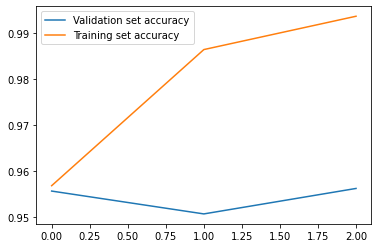

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(history):
    train_metric = 'label_categorical_accuracy'
    val_metric = 'val_label_categorical_accuracy'
    plt.plot(history.history[val_metric],label="Validation set accuracy")
    plt.plot(history.history[train_metric],label="Training set accuracy")
    plt.legend()
    plt.show()


plot_history(history)

## 2.2 Error analysis

Select one model from each of the previous milestones (three models in total). Look at the entities these models predict. Analyze the errors made. Are there any patterns? How do the errors one model makes differ from those made by another?

Simple RNN

In [92]:
#I want to see how the model predicts classes


# Recreate the exact same rnn, including its weights and the optimizer
import tensorflow as tf
from tensorflow.keras.models import load_model

simple_rnn = tf.keras.models.load_model('NEWModel1_Adam0.3.h5')

# Show the model architecture
simple_rnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 168, 300)          15000600  
_________________________________________________________________
dense_1 (Dense)              (None, 168, 50)           15050     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 168, 37)           1887      
Total params: 15,017,537
Trainable params: 16,937
Non-trainable params: 15,000,600
_________________________________________________________________


In [0]:
simple_rnn_predictions = simple_rnn.predict(vectorized_data_padded)  #save predictions

In [94]:
simple_rnn_predictions[0][0]   #see what the output looks like
#The outputs are probabilities for each class (tag)

array([0.4354858 , 0.01699266, 0.01746663, 0.02376078, 0.01758664,
       0.01486108, 0.01326818, 0.00977711, 0.029234  , 0.01739111,
       0.00686423, 0.01310816, 0.01929541, 0.01577151, 0.01108016,
       0.03385628, 0.02223525, 0.01406394, 0.01525715, 0.00805973,
       0.03214354, 0.0136274 , 0.00238292, 0.01606015, 0.00495875,
       0.01371827, 0.01491944, 0.00959745, 0.01508046, 0.01765896,
       0.00878316, 0.015236  , 0.01735945, 0.01086606, 0.00991656,
       0.01698111, 0.02529456], dtype=float32)

In [0]:
import numpy as np


list_of_tag_args = []    #create a list of saved positions for each entity label
for i in simple_rnn_predictions:
    for j in i:
        temp = np.argmax(j)
        list_of_tag_args.append(temp)

In [96]:
list_of_tag_args  #Now that we have this list, we can use our label map dictionary to identify the actual tag

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [0]:
labels = list(label_map.keys())

decoded_RNN_tags = []
for i in list_of_tag_args:
    decoded_RNN_tags.append(labels[i])

In [98]:
decoded_RNN_tags

['B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',
 'B-DATE',

In [103]:
def rnn_predict_tags(words):
    # This function takes a sequence of words, vectorizes it,
    # and returns the model predictions. The vectorization code
    # we wrote expects labels, so we'll attach dummy labels to
    # use the code and then discard the dummy labels it generates.
    dummy_tagged = [(word, NO_LABEL) for word in words]
    tokenized_test = tokenize_sentences([dummy_tagged])
    test_X, dummy_Y = vectorize_dataset(tokenized_test)
    # Run model.predict for this single sequence 
    predictions = simple_rnn.predict(test_X)
    # Our outputs are one-hot, take argmax to get indices
    y = predictions[0].argmax(axis=1)
    # For words tokenized into several subword parts, we
    # only care about the predicted tag for the first part.
    # Use the tokenization to identify these parts.
    tags = []
    i = 1    # Start at 1 to skip the special [CLS] token.
    for tokens, _ in tokenized_test[0]:
        tags.append(int_to_tag[y[i]])
        i += len(tokens)
    return tags


# Test the model with a few word sequences
test_words = [
  'This model can predict BIO tags quite badly .'.split(),
  'I love eating ice-cream with Dave Grohl and jogging with Madonna to New York and Egypt.'.split()
  ]


for words in test_words:
    tags = rnn_predict_tags(words)
    for w, t in zip(words, tags):
        print('{}\t{}'.format(w, t))
    print()

This	NONE
model	NONE
can	NONE
predict	NONE
BIO	NONE
tags	NONE
quite	B-DATE
badly	NONE
.	NONE

I	B-QUANTITY
love	NONE
eating	NONE
ice-cream	NONE
with	I-TIME
Dave	B-LOC
Grohl	NONE
and	NONE
jogging	NONE
with	I-TIME
Madonna	NONE
to	NONE
New	NONE
York	NONE
and	NONE
Egypt.	NONE



Since our simple RNN model did not have a very good score, it was expected to perform badly. 

LSTM

In [71]:
#I want to see how the model predicts classes


# Recreate the exact same lstm, including its weights and the optimizer
import tensorflow as tf
from tensorflow.keras.models import load_model

lstm = tf.keras.models.load_model('BadLSTMLossDeclining0.04FZero.h5')   #This model has an f-score of 0.99

# Show the model architecture
lstm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 168)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 168, 300)          15000600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 50)           70200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 168, 37)           1887      
Total params: 15,072,687
Trainable params: 72,087
Non-trainable params: 15,000,600
_________________________________________________________________


In [0]:
lstm_predictions = lstm.predict(vectorized_data_padded)  #save predictions

In [74]:
lstm_predictions[0][0]   #see what the output looks like
#The outputs are probabilities for each class (tag)

array([0.02631832, 0.02742383, 0.02606142, 0.02615814, 0.02595535,
       0.02584755, 0.02914128, 0.02726994, 0.02590375, 0.03963802,
       0.02600654, 0.02565163, 0.02797289, 0.02586091, 0.02869107,
       0.02663114, 0.02622616, 0.02715563, 0.02636004, 0.02914733,
       0.02637641, 0.02571471, 0.02558731, 0.02647568, 0.03089567,
       0.02555509, 0.02609051, 0.0259408 , 0.02579284, 0.02857378,
       0.02601798, 0.02698946, 0.02596169, 0.02622531, 0.02574262,
       0.02674478, 0.02589447], dtype=float32)

In [0]:
list_of_lstm_tag_args = []    #create a list of saved positions for each entity label
for i in lstm_predictions:
    for j in i:
        temp = np.argmax(j)
        list_of_lstm_tag_args.append(temp)

In [76]:
list_of_lstm_tag_args  #Now that we have this list, we can use our label map dictionary to identify the actual tag

[9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,


In [0]:
labels = list(label_map.keys())

In [83]:
labels[9]   #short demontration to check how to actually retrieve a tag

'B-MONEY'

In [0]:
decoded_tags = []
for i in list_of_lstm_tag_args:
    decoded_tags.append(labels[i])

In [85]:
decoded_tags   #Since our LSTM model was extremely bad, it is no wonder that it give this bad results :(

['B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-MONEY',
 'B-

In [91]:
def lstm_predict_tags(words):
    # This function takes a sequence of words, vectorizes it,
    # and returns the model predictions. The vectorization code
    # we wrote expects labels, so we'll attach dummy labels to
    # use the code and then discard the dummy labels it generates.
    dummy_tagged = [(word, NO_LABEL) for word in words]
    tokenized_test = tokenize_sentences([dummy_tagged])
    test_X, dummy_Y = vectorize_dataset(tokenized_test)
    # Run model.predict for this single sequence 
    predictions = lstm.predict(test_X)
    # Our outputs are one-hot, take argmax to get indices
    y = predictions[0].argmax(axis=1)
    # For words tokenized into several subword parts, we
    # only care about the predicted tag for the first part.
    # Use the tokenization to identify these parts.
    tags = []
    i = 1    # Start at 1 to skip the special [CLS] token.
    for tokens, _ in tokenized_test[0]:
        tags.append(int_to_tag[y[i]])
        i += len(tokens)
    return tags


# Test the model with a few word sequences
test_words = [
  'This model can predict BIO tags quite badly .'.split(),
  'I love eating ice-cream with Dave Grohl .'.split()
  ]


for words in test_words:
    tags = lstm_predict_tags(words)
    for w, t in zip(words, tags):
        print('{}\t{}'.format(w, t))
    print()

This	B-MONEY
model	B-MONEY
can	B-MONEY
predict	B-MONEY
BIO	B-MONEY
tags	B-MONEY
quite	B-MONEY
badly	B-MONEY
.	B-MONEY

I	B-MONEY
love	B-MONEY
eating	B-MONEY
ice-cream	B-MONEY
with	B-MONEY
Dave	B-MONEY
Grohl	B-MONEY
.	B-MONEY



Our LSTM had an accuracy of zero and we had huge problems with it while training, so this is the worst model we have by far.

BERT

In [69]:
def predict_tags(words):
    # This function takes a sequence of words, vectorizes it,
    # and returns the model predictions. The vectorization code
    # we wrote expects labels, so we'll attach dummy labels to
    # use the code and then discard the dummy labels it generates.
    dummy_tagged = [(word, NO_LABEL) for word in words]
    tokenized_test = tokenize_sentences([dummy_tagged])
    test_X, dummy_Y = vectorize_dataset(tokenized_test)
    # Run model.predict for this single sequence 
    predictions = model.predict(test_X)
    # Our outputs are one-hot, take argmax to get indices
    y = predictions[0].argmax(axis=1)
    # For words tokenized into several subword parts, we
    # only care about the predicted tag for the first part.
    # Use the tokenization to identify these parts.
    tags = []
    i = 1    # Start at 1 to skip the special [CLS] token.
    for tokens, _ in tokenized_test[0]:
        tags.append(int_to_tag[y[i]])
        i += len(tokens)
    return tags


# Test the model with a few word sequences
test_words = [
  'This model can predict BIO tags .'.split(),
  'What would the best time in recent years, Michael Jackson wondered quietly in July .'.split()
]


for words in test_words:
    tags = predict_tags(words)
    for w, t in zip(words, tags):
        print('{}\t{}'.format(w, t))
    print()

This	O
model	O
can	O
predict	O
BIO	O
tags	O
.	O

What	O
would	O
the	O
best	O
time	O
in	O
recent	B-DATE
years,	I-DATE
Michael	B-PERSON
Jackson	I-PERSON
wondered	O
quietly	O
in	O
July	B-DATE
.	O



In [70]:
# Test the model with a few more word sequences
test_words = [
  'This model can predict BIO tags .'.split(),
  'I am evil Homer! Kurt Cobain rocks since 1990 .'.split()
]


for words in test_words:
    tags = predict_tags(words)
    for w, t in zip(words, tags):
        print('{}\t{}'.format(w, t))
    print()

This	O
model	O
can	O
predict	O
BIO	O
tags	O
.	O

I	O
am	O
evil	O
Homer!	B-PERSON
Kurt	B-PERSON
Cobain	I-PERSON
rocks	O
since	O
1990	B-DATE
.	O



Luckily, BERT gave some great results while training, as well as when looking at the predictions, so this is nice!

## 3.1 Predictions on unannotated text

Use the three models selected in milestone 2.2 to do predictions on the sampled wikipedia text.

## 3.2 Statistically analyze the results

Statistically analyze (i.e. count the number of instances) and compare the predictions. You can, for example, analyze if some models tend to predict more entities starting with a capital letter, or if some models predict more entities for some specific classes than others.